In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import sys, os


os.chdir("/Users/samuel.gruffaz/leaspype_kernel/leaspy")

from leaspy.api import Leaspy

from leaspy import Leaspy, Data, AlgorithmSettings, Plotter, Dataset, IndividualParameters
from leaspy.models.utils.attributes.attributes_factory import AttributesFactory
from leaspy.algo.algo_factory import AlgoFactory
from leaspy.utils.visualisation.visual_update_b import *




In [6]:
def generate_data(model, n_individuals, nb_visits_min, nb_visits_mean, window):
    # Sampling individuals :

    N = n_individuals

    individuals = []

    data = [[], []] + [[] for k in range(model.dimension)]

    for i in range(N):
        tau = np.random.normal(loc=model.parameters['tau_mean'], scale=model.parameters['tau_std'])
        xi = np.random.normal(loc=model.parameters['xi_mean'], scale=model.parameters['xi_std'])
        n_tpts = nb_visits_min + np.random.binomial(2 * (nb_visits_mean-nb_visits_min),0.5)
        tpts = np.sort((np.random.normal(0., 1., size=(n_tpts)) * window) + tau)
        timepoints = torch.tensor(tpts, dtype=float)
        sources = None
        if model.source_dimension is not None:
            sources = np.random.normal(loc=model.parameters['sources_mean'], scale=model.parameters['sources_std'], size=(model.source_dimension))
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi), "sources":torch.Tensor(sources)}).detach().numpy()
        else:   
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi)}).detach().numpy()
        values = values + np.random.normal(0., model.parameters['noise_std'], size=(n_tpts, model.dimension))
        individuals.append({"idx":i+1, "tau":tau, "xi":xi, "tpts":tpts, "sources":sources, "values":values})
        data[0] += [i+1] * n_tpts
        data[1] += list(tpts)
        for k in range(model.dimension):
            data[2+k] += list(values[0, :, k])
    data = np.array(data).T
    df = pd.DataFrame(data, columns=['ID', 'TIME']+["Y"+str(k+1) for k in range(model.dimension)])
    df.set_index(['ID', 'TIME'], inplace=True)
    return df, individuals

def plot_generative(ax, individuals, model1, nb_ind_plot, dimension):

    for i in range(nb_ind_plot):
        params = individuals[i]
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model1.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(individuals[i]['tpts'], individuals[i]['values'][0,:,j], "o")
            ax[i,j].plot(t, trajectory[..., j])

def plot_points(ax, dataset, nb_ind_plot, dimension):
    tps=dataset.timepoints
    Y=dataset.values
    mask=dataset.mask
    for i in range(nb_ind_plot):
        ind=mask[i].bool().all(axis=1)
        
        Z=Y[i,ind]
        tpsi=tps[i,ind]
       
      
        for j in range(dimension):
            ax[i,j].plot(tpsi, Z[:,j], "o")
            

def plot_fit(ax, results, model, dataset,nb_ind_plot, dimension):
    tps=dataset.timepoints
    
    for i in range(nb_ind_plot):
        tpts=tps[i,:dataset.nb_observations_per_individuals[i]].numpy()
        
        params = results._individual_parameters[results._indices[i]]
        params["tpts"]=tpts
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(t, trajectory[..., j])

1


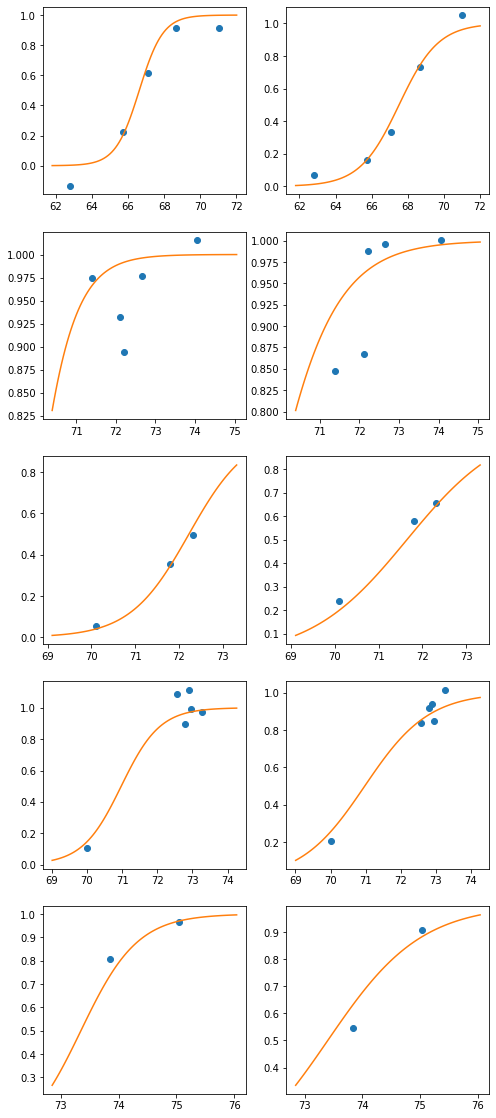

In [7]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.07]}
model1 = leaspy.model
leaspy.model.dimension = dimension
leaspy.model.source_dimension = sources_dimension
leaspy.model.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
leaspy.model.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
leaspy.model.attributes._compute_positions(model1.parameters)
leaspy.model.attributes._compute_velocities(model1.parameters)
leaspy.model.attributes._compute_betas(model1.parameters)
leaspy.model.attributes._compute_orthonormal_basis()
leaspy.model.attributes._compute_mixing_matrix()
leaspy.model.is_initialized = True

print(leaspy.model.source_dimension)
model1=leaspy.model
periode = 15.
amplitude = 2.
model1.B = lambda x : 1./(1.+torch.exp(-x))

n_individuals = 500
nb_visits_min = 2
nb_visits_mean = 4
window = 2.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

leaspy_data = Data.from_dataframe(data)

nb_ind_plot = 5

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(dimension * 4, nb_ind_plot * 4))

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plt.show()

sigma med
tensor(0.5722)
|##################################################|   1500/1500 iterations
The standard deviation of the noise at the end of the calibration is:
Y1: 0.0704
Y2: 0.0694

Calibration took: 13s

The standard deviation of the noise at the end of the personalization is:
Y1: 0.0741
Y2: 0.0633

Personalization scipy_minimize took: 42s
erreur projection
0.0025758701
temps opti quadra
0.017275999999995406
norme W
tensor([4.0646, 0.9804])
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
Y1: 0.0861
Y2: 0.0744

Calibration took: 28s

The standard deviation of the noise at the end of the personalization is:
Y1: 0.0750
Y2: 0.0644

Personalization scipy_minimize took: 57s
erreur projection
0.0022035209
temps opti quadra
0.012338999999997213
norme W
tensor([1.1912, 3.5378])
|##################################################|   200/200 iterations
The standard deviation of the noise a

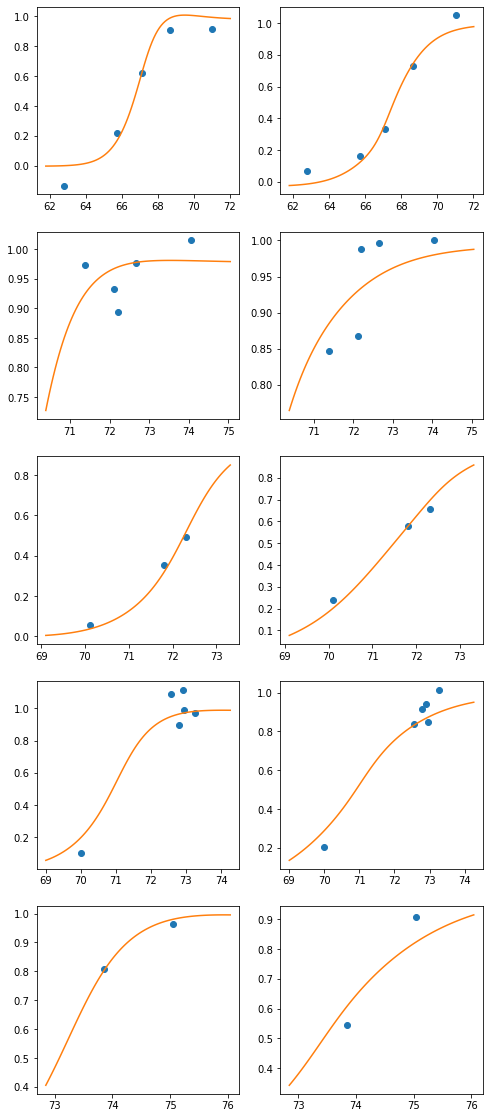

In [10]:
#500 patients
leaspy_test = Leaspy('linearB')
nb_ind_plot=5
dimension=2
leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True,
                 "nb_control_points" : 10,"nb_compose":10,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'logistic'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1500, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
#plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
leaspy_test.save('example/start/outputs/logs/stab.json')   
plt.show()

In [8]:
leaspy_test=Leaspy.load('example/start/outputs/logs/stab.json'  )

/Users/samuel.gruffaz/leaspype_kernel/leaspy/leaspy/models/linear_B.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W1=torch.tensor(W, dtype=torch.float32).clone()
/Users/samuel.gruffaz/leaspype_kernel/leaspy/leaspy/models/linear_B.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_filtre1=torch.tensor(X_filtre, dtype=torch.float32).clone()


In [9]:
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True, 
                 "nb_control_points" : 10,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'iter_begin_fit':100,'init_real':results}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE',progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
    
plt.show()

NameError: name 'results' is not defined

10
norme W
tensor([4.0646, 0.9804])
norme W
tensor([1.1912, 3.5378])
norme W
tensor([9.5394, 1.0467])
norme W
tensor([2.0359, 2.2102])
norme W
tensor([4.1489, 0.9684])
norme W
tensor([7.5037, 3.9871])
norme W
tensor([1.7897, 0.7093])
norme W
tensor([5.1220, 2.4221])
norme W
tensor([2.1957, 1.4675])
norme W
tensor([2.2911, 2.2998])
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


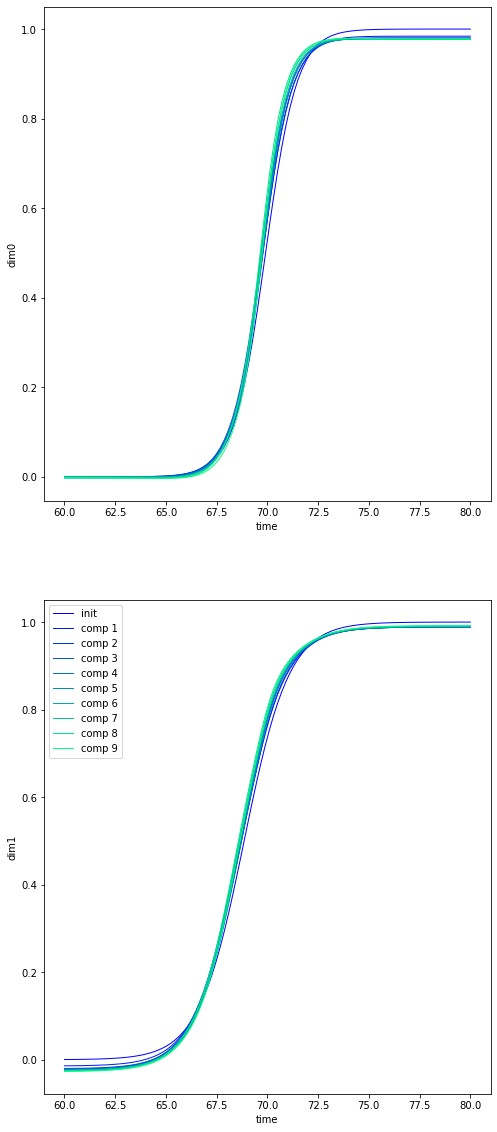

In [11]:
from leaspy.utils.visualisation.visual_update_b import *
dimension=2
nb_ind_plot=5

fig, ax = plt.subplots(dimension, figsize=(4*dimension,4*nb_ind_plot))

plot_average_update(leaspy_test,ax)
plt.legend()
fig.show()

1


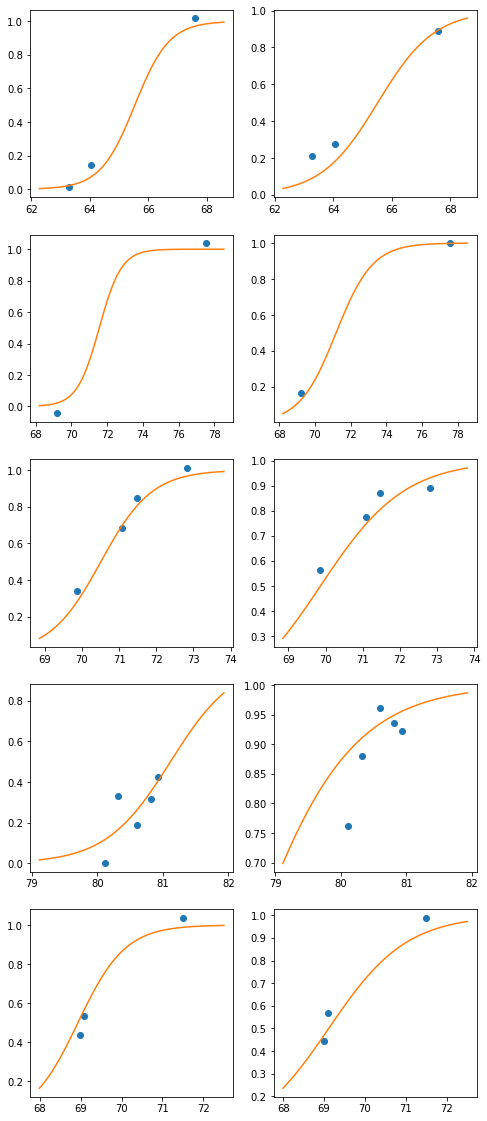

In [22]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [0.1,0.1]}
model1 = leaspy.model
leaspy.model.dimension = dimension
leaspy.model.source_dimension = sources_dimension
leaspy.model.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
leaspy.model.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
leaspy.model.attributes._compute_positions(model1.parameters)
leaspy.model.attributes._compute_velocities(model1.parameters)
leaspy.model.attributes._compute_betas(model1.parameters)
leaspy.model.attributes._compute_orthonormal_basis()
leaspy.model.attributes._compute_mixing_matrix()
leaspy.model.is_initialized = True

print(leaspy.model.source_dimension)
model1=leaspy.model
periode = 15.
amplitude = 2.
model1.B = lambda x : 1./(1.+torch.exp(-x))

n_individuals = 500
nb_visits_min = 2
nb_visits_mean = 4
window = 2.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

leaspy_data = Data.from_dataframe(data)

nb_ind_plot = 5

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(dimension * 4, nb_ind_plot * 4))

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plt.show()

sigma med
tensor(0.5807)
|##################################################|   1500/1500 iterations
The standard deviation of the noise at the end of the calibration is:
Y1: 0.0997
Y2: 0.1017

Calibration took: 26s

The standard deviation of the noise at the end of the personalization is:
Y1: 0.1101
Y2: 0.0957

Personalization scipy_minimize took: 1min 6s
erreur projection
0.000733861
temps opti quadra
0.015240000000630971
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
Y1: 0.1259
Y2: 0.1103

Calibration took: 32s

The standard deviation of the noise at the end of the personalization is:
Y1: 0.1107
Y2: 0.0966

Personalization scipy_minimize took: 1min 32s
erreur projection
0.0024804112
temps opti quadra
0.009840999999141786
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
Y1: 0.1278
Y2: 0.1114

Ca

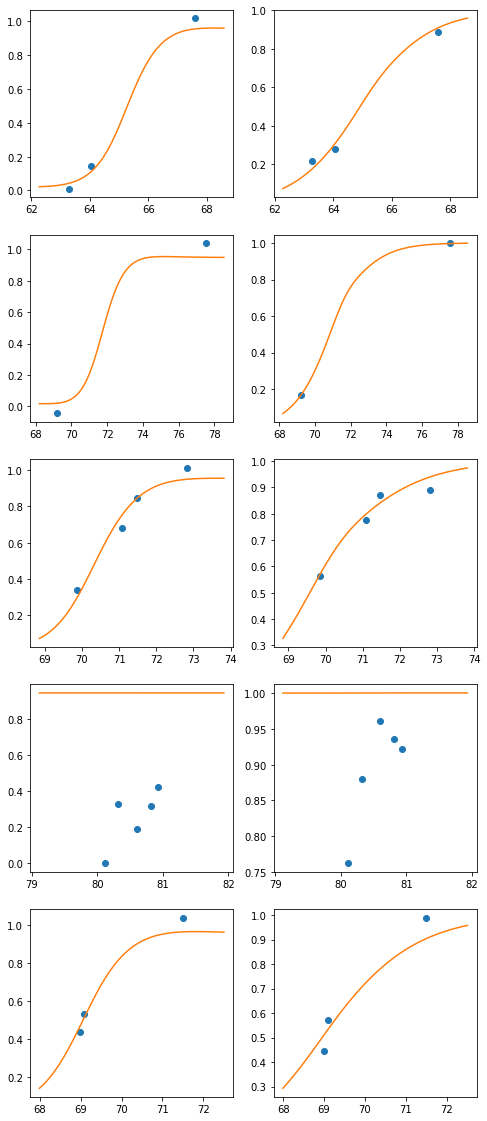

In [23]:
#500 patients
leaspy_test = Leaspy('linearB')
nb_ind_plot=5
dimension=2
leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True,
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'logistic'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1500, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
#plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
leaspy_test.save('example/start/outputs/logs/stab02.json')   
plt.show()

c'est mieux de prendre peu de patients

sigma med
tensor(0.5698)
|##################################################|   1500/1500 iterations
The standard deviation of the noise at the end of the calibration is:
Y1: 0.0690
Y2: 0.0677

Calibration took: 16s

The standard deviation of the noise at the end of the personalization is:
Y1: 0.0711
Y2: 0.0828

Personalization scipy_minimize took: 14s
erreur projection
0.0012029812
temps opti quadra
0.00560100000075181
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
Y1: 0.0828
Y2: 0.0945

Calibration took: 11s

The standard deviation of the noise at the end of the personalization is:
Y1: 0.0712
Y2: 0.0827

Personalization scipy_minimize took: 15s
erreur projection
0.0017092478
temps opti quadra
0.013770000000477012
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
Y1: 0.0825
Y2: 0.0977

Calibration

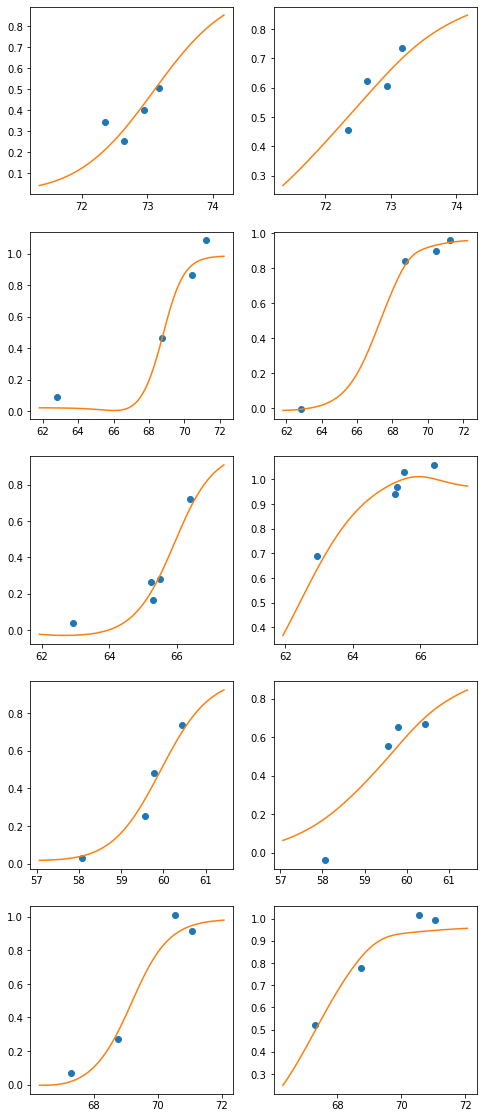

In [13]:
#500 patients
leaspy_test = Leaspy('linearB')
nb_ind_plot=5
dimension=2
leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True,
                 "nb_control_points" : 10,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'logistic'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1500, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
#plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
leaspy_test.save('example/start/outputs/logs/stab.json')   
plt.show()

5
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


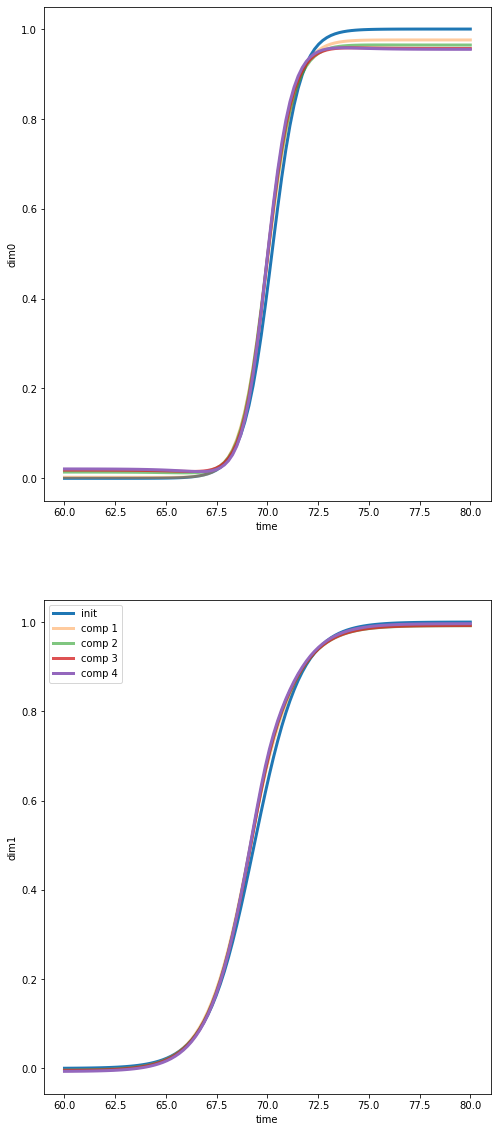

In [24]:
dimension=2
nb_ind_plot=5

fig, ax = plt.subplots(dimension, figsize=(4*dimension,4*nb_ind_plot))

plot_average_update(leaspy_test,ax)
plt.legend()
fig.show()

In [14]:
torch.norm(torch.tensor([1.,2.]))

tensor(2.2361)

Si on a beaucoup de patients, on a une tendance à l'overditting, c'est étrange, peut être c'est parce qu'il y a plus de bruit